In [1]:
import warnings
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
from sklearn import linear_model
warnings.filterwarnings("ignore")
from sklearn.metrics import r2_score
import statsmodels.formula.api as smf
from sklearn.pipeline import Pipeline
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import PolynomialFeatures, StandardScaler

In [2]:
data = pd.read_csv('Hitters.csv')
data = pd.get_dummies(data, columns=['League','Division','NewLeague'])
target = 'Salary'
data = data[data['Salary'].notnull()]

In [3]:
def calibracion(predicciones, y, bins):
    df_calibracion = pd.DataFrame({
        'predicciones': predicciones,
        'y': y
    })
    df_calibracion['bins'] = pd.qcut(df_calibracion['predicciones'], q = bins, labels=False) + 1
    grouped = df_calibracion.groupby('bins').mean()
    plt.plot(grouped.predicciones, grouped.y, marker='o', label = 'Modelo', color = 'skyblue')
    plt.plot(grouped.predicciones, grouped.predicciones, marker='o', label = 'Real', color = 'indianred')
    plt.xlabel('Predicción')
    plt.ylabel('Real')
    plt.legend()
    plt.grid()

## Regresión lineal Examen

In [4]:
# De rendimiento actual
data['Hits_per_AtBat'] = data['Hits'] / data['AtBat']
data['HmRun_per_Hits'] = data['HmRun'] / data['Hits']
data['RBIs_per_Hits'] = data['RBI'] / data['Hits']
data['Runs_per_Hits'] = data['Runs'] / data['Hits']

# De rendimiento histórico
data['CHits_per_CAtBat'] = data['CHits'] / data['CAtBat']
data['CHmRun_per_CHits'] = data['CHmRun'] / data['CHits']
data['CRuns_per_CHits'] = data['CRuns'] / data['CHits']
data['Years_AvgHits'] = data['CHits'] / data['Years']

# Transformaciones
data['log_CRuns'] = np.log(data['CRuns']+1)
data['sqrt_CHits'] = np.sqrt(data['CHits']+1)

In [5]:
X = data.copy()
X = X.drop(columns=[target])
y = data[target]

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [7]:
model = linear_model.LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(f'R2: {r2_score(y_test, y_pred):.4f}')

R2: 0.7134


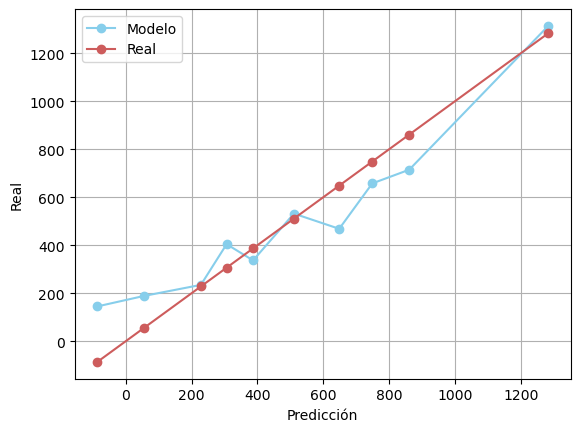

In [8]:
calibracion(y_pred, y_test, 10)

## Red Neuronal

In [9]:
# Pipeline
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('nn', MLPRegressor())
])
# Params grid
params_grid = {
    'nn__hidden_layer_sizes': [(50,25,50), (32,64,128), (100,50,100), (10,10,10)],
    'nn__activation': ['tanh', 'relu', 'logistic'],
    'nn__alpha': [0.1, 0.01]
}
# Fit model
grid_nn = GridSearchCV(estimator=pipeline, param_grid=params_grid, n_jobs=-1, cv=5, scoring='r2')
grid_nn.fit(X_train, y_train)

/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('nn', MLPRegressor())]),
             n_jobs=-1,
             param_grid={'nn__activation': ['tanh', 'relu', 'logistic'],
                         'nn__alpha': [0.1, 0.01],
                         'nn__hidden_layer_sizes': [(50, 25, 50), (32, 64, 128),
                                                    (100, 50, 100),
                                                    (10, 10, 10)]},
             scoring='r2')

In [10]:
grid_nn.best_params_

{'nn__activation': 'relu',
 'nn__alpha': 0.1,
 'nn__hidden_layer_sizes': (32, 64, 128)}

In [11]:
# Calcular R2
pred_nn = grid_nn.best_estimator_.predict(X_test)
print(f'R2: {r2_score(y_test, pred_nn):.4f}')

R2: 0.3596


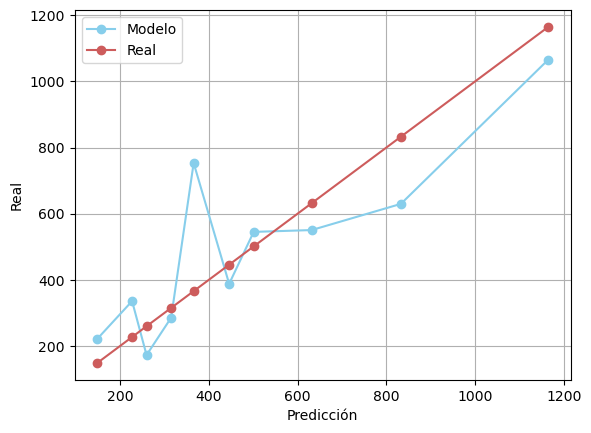

In [12]:
calibracion(pred_nn, y_test, 10)

## Tensorflow

In [13]:
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization

In [14]:
# Custom R² metric function
def r2_metric(y_true, y_pred):
    SS_res = tf.reduce_sum(tf.square(y_true - y_pred))
    SS_tot = tf.reduce_sum(tf.square(y_true - tf.reduce_mean(y_true)))
    return 1 - SS_res / (SS_tot + tf.keras.backend.epsilon())

# Build the model
model = Sequential([
    Dense(100, activation='relu', input_shape=(X_train.shape[1],)),  # First hidden layer
    BatchNormalization(),  # Batch normalization layer
    Dropout(0.2),  # Dropout layer

    Dense(50, activation='relu'),  # Second hidden layer
    BatchNormalization(),  # Batch normalization layer
    Dropout(0.1),  # Dropout layer

    Dense(100, activation='tanh'),  # Third hidden layer
    BatchNormalization(),  # Batch normalization layer
    Dropout(0.1),  # Dropout layer
    
    Dense(1)  # Output layer (regression)
])

# Compile the model with Adam optimizer and Mean Squared Error (MSE) loss
model.compile(optimizer=Adam(learning_rate=0.01), loss='mse', metrics=[r2_metric])

# Train the model
history = model.fit(X_train, y_train, epochs=150, batch_size=32, validation_data=(X_test, y_test), verbose=1)

# Evaluate the model
pred_tf = model.predict(X_test)
pred_tf = pred_tf.flatten()

r2 = r2_score(y_test, pred_tf)
print(f'R² Score: {r2:.4f}')

Epoch 1/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 545456.3750 - r2_metric: -1.5301 - val_loss: 421814.2188 - val_r2_metric: -1.3469
Epoch 2/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 443401.3125 - r2_metric: -1.6219 - val_loss: 413131.0312 - val_r2_metric: -1.2948
Epoch 3/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 517982.9688 - r2_metric: -1.3676 - val_loss: 403543.5000 - val_r2_metric: -1.2384
Epoch 4/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 494544.6250 - r2_metric: -1.2396 - val_loss: 390519.5625 - val_r2_metric: -1.1618
Epoch 5/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 472840.6250 - r2_metric: -1.3724 - val_loss: 375389.2812 - val_r2_metric: -1.0731
Epoch 6/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 417505.5000 - r2_metric: -1.1038 - val_loss: 358273.5000 - val_r2_metric: -0.9740
Epoch 7/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 410692.6250 - r2_metric: -1.1620 - val_loss: 339980.5938 - val_r2_metric: -0.8676
Epoch 8/150
7/7 ━━━━━━━━━━

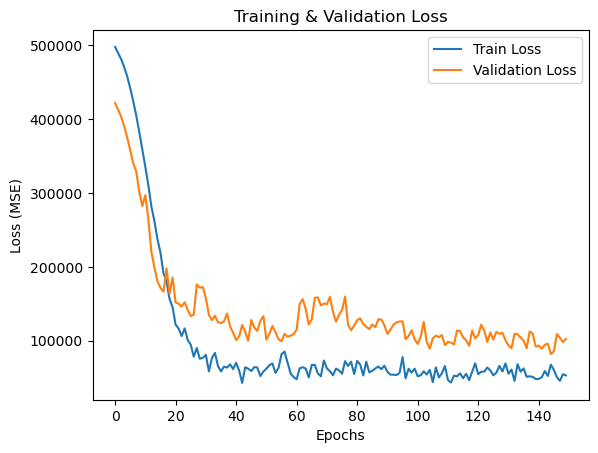

In [15]:
# Extract loss history
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.title('Training & Validation Loss')
plt.legend()
plt.show()


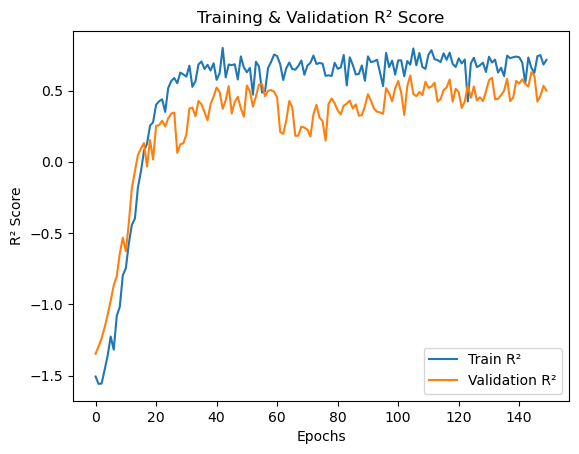

In [16]:
plt.plot(history.history['r2_metric'], label='Train R²')
plt.plot(history.history['val_r2_metric'], label='Validation R²')
plt.xlabel('Epochs')
plt.ylabel('R² Score')
plt.title('Training & Validation R² Score')
plt.legend()
plt.show()

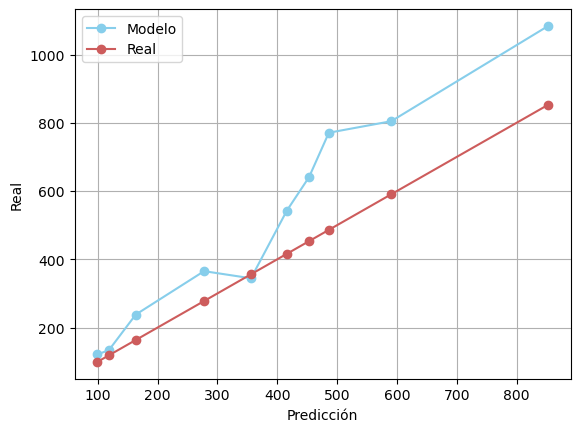

In [17]:
calibracion(pred_tf, y_test, 10)

## Save model

In [18]:
#model.save('exam1.keras')

In [20]:
loaded_model = tf.keras.models.load_model('exam1.keras', custom_objects={'r2_metric': r2_metric})
predictions = loaded_model.predict(X_test).flatten()
r2_score(y_test, predictions)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


0.5959226294504976